Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/pi/ai/corenlp/de_gsd_models/de_gsd_tokenizer.pt', 'lang': 'de', 'shorthand': 'de_gsd', 'mode': 'predict'}
---
Loading: mwt
With settings: 
{'model_path': '/pi/ai/corenlp/de_gsd_models/de_gsd_mwt_expander.pt', 'lang': 'de', 'shorthand': 'de_gsd', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
---
Loading: pos
With settings: 
{'model_path': '/pi/ai/corenlp/de_gsd_models/de_gsd_tagger.pt', 'pretrain_path': '/pi/ai/corenlp/de_gsd_models/de_gsd.pretrain.pt', 'lang': 'de', 'shorthand': 'de_gsd', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/pi/ai/corenlp/de_gsd_models/de_gsd_lemmatizer.pt', 'lang': 'de', 'shorthand': 'de_gsd', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit clas

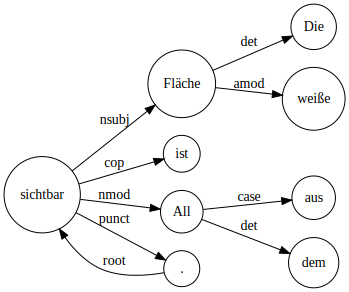

In [13]:
from sagas.nlu.corenlp_helper import CoreNlp, CoreNlpViz, langs
nlp=langs['de']()
CoreNlpViz().analyse('Die weiße Fläche ist aus dem All sichtbar.', nlp)

text: Die 	lemma: der	upos: DET	xpos: ART
text: Eltern 	lemma: Eltern	upos: NOUN	xpos: NN
text: mögen 	lemma: mögen	upos: VERB	xpos: VVFIN
text: den 	lemma: der	upos: DET	xpos: ART
text: Käse 	lemma: Käse	upos: NOUN	xpos: NN
text: . 	lemma: .	upos: PUNCT	xpos: $.
('Die', '2', 'det')
('Eltern', '3', 'nsubj')
('mögen', '0', 'root')
('den', '5', 'det')
('Käse', '3', 'obj')
('.', '3', 'punct')


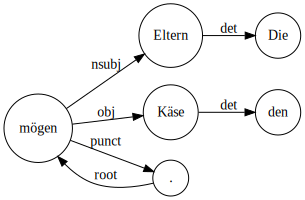

In [14]:
sents='Die Eltern mögen den Käse.'
CoreNlpViz().analyse(sents, nlp)

text: Wie 	lemma: wie	upos: ADV	xpos: PWAV
text: erhöhst 	lemma: erhöhsen	upos: VERB	xpos: VVFIN
text: du 	lemma: du	upos: PRON	xpos: PPER
text: die 	lemma: der	upos: DET	xpos: ART
text: Nummern 	lemma: Nummer	upos: NOUN	xpos: NN
text: ? 	lemma: ?	upos: PUNCT	xpos: $.
('Wie', '2', 'advmod')
('erhöhst', '0', 'root')
('du', '2', 'nsubj')
('die', '5', 'det')
('Nummern', '2', 'obj')
('?', '2', 'punct')


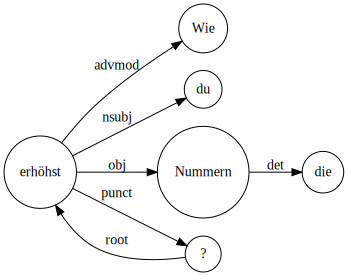

In [48]:
sents='Wie erhöhst du die Nummern?'
CoreNlpViz().analyse(sents, nlp)

In [15]:
doc = nlp(sents)
print(*[f'text: {word.text+" "}\tlemma: {word.lemma}\tpos: {word.pos}\tupos: {word.upos}\txpos: {word.xpos}' for sent in
                doc.sentences for word in sent.words], sep='\n')

text: Die 	lemma: der	pos: ART	upos: DET	xpos: ART
text: Eltern 	lemma: Eltern	pos: NN	upos: NOUN	xpos: NN
text: mögen 	lemma: mögen	pos: VVFIN	upos: VERB	xpos: VVFIN
text: den 	lemma: der	pos: ART	upos: DET	xpos: ART
text: Käse 	lemma: Käse	pos: NN	upos: NOUN	xpos: NN
text: . 	lemma: .	pos: $.	upos: PUNCT	xpos: $.


In [16]:
import sagas
t=[(word.text, word.lemma, word.upos, word.xpos) for sent in
                doc.sentences for word in sent.words]
display(sagas.to_df(t, ['text', 'lemma', 'upos', 'xpos']))

,text,lemma,upos,xpos
0,Die,der,DET,ART
1,Eltern,Eltern,NOUN,NN
2,mögen,mögen,VERB,VVFIN
3,den,der,DET,ART
4,Käse,Käse,NOUN,NN
5,.,.,PUNCT,$.


In [19]:
t=[(word.text, word.lemma) for sent in
                doc.sentences for word in sent.words if word.upos=='VERB']
t

[('mögen', 'mögen')]

In [34]:
from yaml.dumper import Dumper
from yaml.representer import SafeRepresenter

class KludgeDumper(Dumper):
    pass

KludgeDumper.add_representer(str,
       SafeRepresenter.represent_str)
# KludgeDumper.add_representer(unicode,
#         SafeRepresenter.represent_unicode)

In [40]:
import json
def get_doc_verbs(doc):
    return [(word.text, word.lemma) for sent in
                doc.sentences for word in sent.words if word.upos=='VERB']
def get_doc_root(doc):
    root=''
    segs=doc.sentences[0]
    for dep_edge in segs.dependencies:
        # print(dep_edge[2].text, dep_edge[0].index, dep_edge[1])
        if dep_edge[1]=='root':
            root=dep_edge[2].text
    return root

# print(get_doc_root(doc))
data={'root':get_doc_root(doc), 'verbs':get_doc_verbs(doc)}
# data_y=yaml.dump(data, default_flow_style=True,Dumper=KludgeDumper,encoding=None)
data_y=json.dumps(data, ensure_ascii=False)
print(data_y)

{"root": "mögen", "verbs": [["mögen", "mögen"]]}


In [62]:
def get_doc_root_and_idx(doc):
    root=''
    root_idx=0
    cur=1  ## word index starts with 1
    segs=doc.sentences[0]    
    for dep_edge in segs.dependencies:
        # print(dep_edge[2].text, dep_edge[0].index, dep_edge[1])
        if dep_edge[1]=='root':
            root=dep_edge[2].text
            root_idx=cur
        cur=cur+1
    return root, root_idx
def in_filters(val, filters):
    for f in filters:
        if val.endswith(f):
            return True
    return False
def get_root_rel(doc, root_idx, filters):
    root=''
    segs=doc.sentences[0]
    rs=[]
    for dep_edge in segs.dependencies:
        print(dep_edge[2].text, dep_edge[0].index, str(dep_edge[1]))
        # if dep_edge[0].index==str(root_idx) and str(dep_edge[1]) in filters:
        # if dep_edge[0].index==str(root_idx):
        if dep_edge[0].index==str(root_idx) and in_filters(str(dep_edge[1]), filters):
            rs.append((dep_edge[1], dep_edge[2].text))
    return rs

sents='Wie erhöhst du die Nummern?'
doc=nlp(sents)
root, root_idx=get_doc_root_and_idx(doc)
print('**', root, root_idx)
rs=get_root_rel(doc, root_idx, ['subj', 'obj'])
rs

** erhöhst 2
Wie 2 advmod
erhöhst 0 root
du 2 nsubj
die 5 det
Nummern 2 obj
? 2 punct


[('nsubj', 'du'), ('obj', 'Nummern')]

In [2]:
import yaml
r=yaml.dump({'name': 'Silenthand Olleander', 'race': 'Human','traits': ['ONE_HAND', 'ONE_EYE']})
print(r)

name: Silenthand Olleander
race: Human
traits: [ONE_HAND, ONE_EYE]



In [5]:
document = """
  a: 1
  b:
    c: 3
    d: 4
"""
doc=yaml.load(document)
print(doc['b'])

{'c': 3, 'd': 4}


In [11]:
data={'verbs':['Hesperiidae', 'Papilionidae', 'Apatelodidae', 'Epiplemidae'], 'root':'Run'}
# doc=yaml.load(data)
print(yaml.dump(data, default_flow_style=True))

{root: Run, verbs: [Hesperiidae, Papilionidae, Apatelodidae, Epiplemidae]}



In [68]:
import requests
data = {'lang':'de', "sents":"Die Eltern mögen den Käse."}
response = requests.post('http://localhost:8090/digest', json=data)
print(response.status_code, response.json())

200 {'lang': 'de', 'root': 'mögen', 'verbs': [['mögen', 'mögen']], 'nsubj': 'Eltern', 'obj': 'Käse'}


In [84]:
from termcolor import colored
import requests
sents="Die Eltern mögen den Käse."
data = {'lang':'de', "sents":sents}
response = requests.post('http://localhost:8090/digest', json=data)
# print(response.status_code, response.json())
result=response.json()
for verb in result['verbs']:
    sents=sents.replace(verb[0], colored(verb[0], 'green'))
for item,value in result.items():
    if 'subj' in item:
        sents=sents.replace(value, colored(value, 'red'))
    if 'obj' in item:
        sents=sents.replace(value, colored(value, 'magenta'))
print('result: %s' % (sents))

result: Die Eltern mögen den Käse.


In [69]:
data = {'lang':'ja', "sents":"私達は月に達する。"}
response = requests.post('http://localhost:8090/digest', json=data)
print(response.status_code, response.json())

200 {'lang': 'ja', 'root': '達する', 'verbs': [['達する', '達する']], 'nsubj': '私達', 'iobj': '月'}


In [70]:
response.text

'{"lang": "ja", "root": "達する", "verbs": [["達する", "達する"]], "nsubj": "私達", "iobj": "月"}'

In [71]:
targets='zh-CN;ja'
('ja' in targets)

True

In [72]:
('cn' in targets)

False

In [47]:
print(json.dumps(response.json(), ensure_ascii=False))

{"root": "mögen", "verbs": [["mögen", "mögen"]]}


text: Ich 	lemma: ich	upos: PRON	xpos: PPER
text: bin 	lemma: sein	upos: VERB	xpos: VAFIN
text: ein 	lemma: ein	upos: DET	xpos: ART
text: Student 	lemma: Student	upos: NOUN	xpos: NN
('Ich', '4', 'nsubj')
('bin', '4', 'cop')
('ein', '4', 'det')
('Student', '0', 'root')


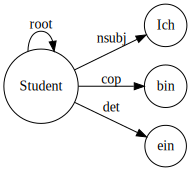

In [63]:
ana=lambda sents: CoreNlpViz().analyse(sents, nlp)
ana('Ich bin ein Student')

    aux: auxiliary，非主要动词和助词，如BE,HAVE SHOULD/COULD等到
    auxpass: passive auxiliary 被动词

text: Ich 	lemma: ich	upos: PRON	xpos: PPER
text: möchte 	lemma: mögen	upos: AUX	xpos: VMFIN
text: , 	lemma: ,	upos: PUNCT	xpos: $,
text: dass 	lemma: dass	upos: SCONJ	xpos: KOUS
text: du 	lemma: du	upos: PRON	xpos: PPER
text: ein 	lemma: ein	upos: DET	xpos: ART
text: Lehrer 	lemma: Lehrer	upos: NOUN	xpos: NN
text: wirst 	lemma: werden	upos: AUX	xpos: VAFIN
text: . 	lemma: .	upos: PUNCT	xpos: $.
('Ich', '2', 'nsubj')
('möchte', '0', 'root')
(',', '2', 'punct')
('dass', '7', 'mark')
('du', '7', 'nsubj')
('ein', '7', 'det')
('Lehrer', '2', 'ccomp')
('wirst', '7', 'cop')
('.', '2', 'punct')


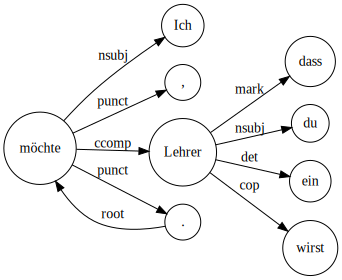

In [2]:
from sagas.nlu.corenlp_helper import CoreNlp, CoreNlpViz, get_nlp
ana=lambda sents: CoreNlpViz().analyse(sents, get_nlp('de'))
ana('Ich möchte, dass du ein Lehrer wirst.')

text: Vielleicht 	lemma: vielleicht	upos: ADV	xpos: ADV
text: wird 	lemma: werden	upos: AUX	xpos: VAFIN
text: er 	lemma: er	upos: PRON	xpos: PPER
text: ein 	lemma: ein	upos: DET	xpos: ART
text: guter 	lemma: gut	upos: ADJ	xpos: ADJA
text: Lehrer 	lemma: Lehrer	upos: NOUN	xpos: NN
text: . 	lemma: .	upos: PUNCT	xpos: $.
('Vielleicht', '6', 'advmod')
('wird', '6', 'cop')
('er', '6', 'nsubj')
('ein', '6', 'det')
('guter', '6', 'amod')
('Lehrer', '0', 'root')
('.', '6', 'punct')


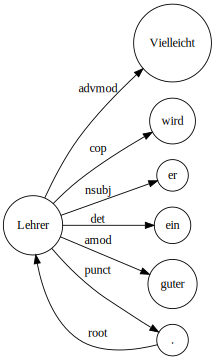

In [3]:
ana('Vielleicht wird er ein guter Lehrer.')

text: Deine 	lemma: dein	upos: PRON	xpos: PPOSAT
text: Stirn 	lemma: Stirn	upos: NOUN	xpos: NN
text: ist 	lemma: sein	upos: AUX	xpos: VAFIN
text: groß 	lemma: groß	upos: ADJ	xpos: ADJD
text: . 	lemma: .	upos: PUNCT	xpos: $.
('Deine', '2', 'det:poss')
('Stirn', '4', 'nsubj')
('ist', '4', 'cop')
('groß', '0', 'root')
('.', '4', 'punct')


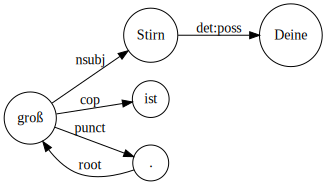

In [4]:
ana('Deine Stirn ist groß.')

text: Was 	lemma: was	upos: PRON	xpos: PWS
text: ist 	lemma: sein	upos: AUX	xpos: VAFIN
text: deine 	lemma: dein	upos: PRON	xpos: PPOSAT
text: Position 	lemma: Position	upos: NOUN	xpos: NN
text: ? 	lemma: ?	upos: PUNCT	xpos: $.
('Was', '4', 'nsubj')
('ist', '4', 'cop')
('deine', '4', 'det:poss')
('Position', '0', 'root')
('?', '4', 'punct')


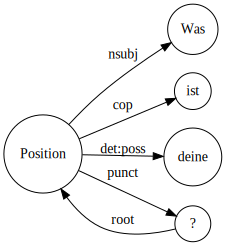

In [5]:
ana('Was ist deine Position?')

In [44]:
from sagas.nlu.corenlp_parser import equals, get_children_list
import sagas

def get_word_features(word):
    # 'c' represent a chunk
    return ['c_{}_{}'.format(word.lemma, word.upos).lower()]

def get_aux_domain(sent, filters):
    rs = []    
    for word in filter(lambda w: w.upos == "AUX", sent.words):
        if word.governor==0:
            # if the aux word is root
            dc=word
        else:
            dc=sent.words[word.governor-1]
        print('℗', word.text, word.dependency_relation, word.governor, '☇' , dc.text)
        # print('\t', dc.index, dc.text, get_children_list(sent, dc))
        domains = []
        # 需要收集的是aux单词依赖的对象的关联集, 而不是aux单词自身的关联集
        for c in filter(lambda w: equals(w.governor, dc.index), sent.words):
            # print('\t', c.index, c.text, get_children_list(sent, c))
            domains.append((c.dependency_relation, c.index, c.text, 
                            get_children_list(sent, c), get_word_features(c)))
        rs.append({'aux': word.text, 'index': word.index, 'domains': domains})
    return rs

# sents='Was ist deine Position?'
# The parties are not tomorrow.
sents='Die Partys sind nicht morgen.'

nlp=get_nlp('de')
doc = nlp(sents)
sent = doc.sentences[0]
rs = get_aux_domain(sent, ['obl', 'nsubj:pass'])
for r in rs:
    df = sagas.to_df(r['domains'], ['rel', 'index', 'text', 'children', 'features'])
    display(df)
# data_y = json.dumps(r, indent=2, ensure_ascii=False)
# print(data_y)

℗ sind root 0 ☇ sind


,rel,index,text,children,features
0,nsubj,2,Partys,"[Die, Partys]",[c_party_noun]
1,advmod,4,nicht,[nicht],[c_nicht_part]
2,advmod,5,morgen,[morgen],[c_morgen_adv]
3,punct,6,.,[.],[c_._punct]


In [43]:
def parse_sents(sents, lang='de'):
    nlp=get_nlp(lang)
    doc = nlp(sents)
    sent = doc.sentences[0]
    return sent
def display_rs(rs):
    for r in rs:
        df = sagas.to_df(r['domains'], ['rel', 'index', 'text', 'children', 'features'])
        display(df)
def get_subj(sent):
    rs = []    
    for word in filter(lambda w: w.dependency_relation.endswith('subj'), sent.words):    
        dc=sent.words[word.governor-1]
        print('℗', word.text, word.dependency_relation, word.governor, '☇' , dc.text)
        domains = []
        # 需要收集的是aux单词依赖的对象的关联集, 而不是aux单词自身的关联集
        for c in filter(lambda w: equals(w.governor, dc.index), sent.words):
            # print('\t', c.index, c.text, get_children_list(sent, c))
            domains.append((c.dependency_relation, c.index, c.text, 
                            get_children_list(sent, c), get_word_features(c)))
        rs.append({'type':'subj_domains', 'subj': word.text, 'index': word.index, 'domains': domains})
    return rs

rs=get_subj(parse_sents('Die Partys sind nicht morgen.'))
display_rs(rs)

℗ Partys nsubj 3 ☇ sind


,rel,index,text,children,features
0,nsubj,2,Partys,"[Die, Partys]",[c_party_noun]
1,advmod,4,nicht,[nicht],[c_nicht_part]
2,advmod,5,morgen,[morgen],[c_morgen_adv]
3,punct,6,.,[.],[c_._punct]


text: Wo 	lemma: wo	upos: ADV	xpos: PWAV
text: ist 	lemma: sein	upos: AUX	xpos: VAFIN
text: die 	lemma: der	upos: DET	xpos: ART
text: Anleitung 	lemma: Anleitung	upos: NOUN	xpos: NN
text: ? 	lemma: ?	upos: PUNCT	xpos: $.
('Wo', '2', 'advmod')
('ist', '0', 'root')
('die', '4', 'det')
('Anleitung', '2', 'nsubj')
('?', '2', 'punct')


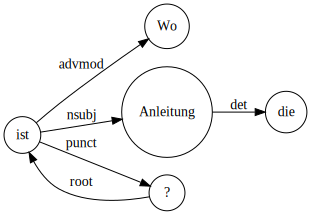

In [26]:
ana('Wo ist die Anleitung?')

text: Wir 	lemma: wir	upos: PRON	xpos: PPER
text: rennen 	lemma: rennen	upos: VERB	xpos: VVFIN
text: durch 	lemma: durch	upos: ADP	xpos: APPR
text: die 	lemma: der	upos: DET	xpos: ART
text: Felder 	lemma: Feld	upos: NOUN	xpos: NN
text: . 	lemma: .	upos: PUNCT	xpos: $.
('Wir', '2', 'nsubj')
('rennen', '0', 'root')
('durch', '5', 'case')
('die', '5', 'det')
('Felder', '2', 'obl')
('.', '2', 'punct')


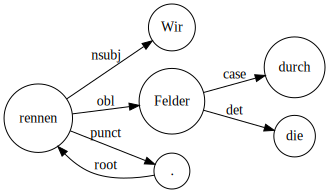

In [27]:
ana('Wir rennen durch die Felder.')

text: Die 	lemma: der	upos: DET	xpos: ART
text: Partys 	lemma: Party	upos: NOUN	xpos: NN
text: sind 	lemma: sein	upos: AUX	xpos: VAFIN
text: nicht 	lemma: nicht	upos: PART	xpos: PTKNEG
text: morgen 	lemma: morgen	upos: ADV	xpos: ADV
text: . 	lemma: .	upos: PUNCT	xpos: $.
('Die', '2', 'det')
('Partys', '3', 'nsubj')
('sind', '0', 'root')
('nicht', '3', 'advmod')
('morgen', '3', 'advmod')
('.', '3', 'punct')


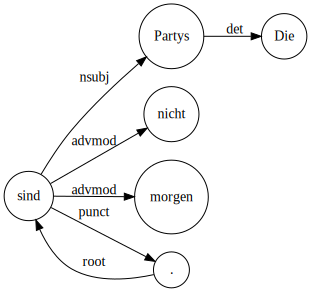

In [48]:
ana('Die Partys sind nicht morgen .')

text: Welche 	lemma: welch	upos: PRON	xpos: PWAT
text: Hobbys 	lemma: Hobbys	upos: NOUN	xpos: NN
text: hast 	lemma: haben	upos: AUX	xpos: VAFIN
text: du 	lemma: du	upos: PRON	xpos: PPER
text: ? 	lemma: ?	upos: PUNCT	xpos: $.
('Welche', '2', 'det')
('Hobbys', '3', 'obj')
('hast', '0', 'root')
('du', '3', 'nsubj')
('?', '3', 'punct')


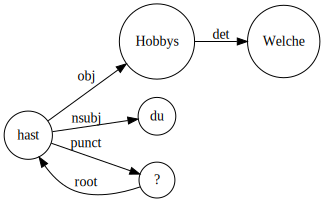

In [46]:
ana('Welche Hobbys hast du ?')

In [53]:
def fix_sents(lang, text):
    if lang in ['de']:
        text=text.strip()
        if text[-1] not in ['!','?','.']:
            return '%s .'%text
        if text[-2]!=' ':
            return '%s %s'%(text[0:-1], text[-1])
    return text
print(fix_sents('de', 'Welche Hobbys hast du'))
print(fix_sents('de', 'Welche Hobbys hast du?'))

Welche Hobbys hast du .
Welche Hobbys hast du ?


Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/pi/ai/corenlp/de_gsd_models/de_gsd_tokenizer.pt', 'lang': 'de', 'shorthand': 'de_gsd', 'mode': 'predict'}
---
Loading: mwt
With settings: 
{'model_path': '/pi/ai/corenlp/de_gsd_models/de_gsd_mwt_expander.pt', 'lang': 'de', 'shorthand': 'de_gsd', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
---
Loading: pos
With settings: 
{'model_path': '/pi/ai/corenlp/de_gsd_models/de_gsd_tagger.pt', 'pretrain_path': '/pi/ai/corenlp/de_gsd_models/de_gsd.pretrain.pt', 'lang': 'de', 'shorthand': 'de_gsd', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/pi/ai/corenlp/de_gsd_models/de_gsd_lemmatizer.pt', 'lang': 'de', 'shorthand': 'de_gsd', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit clas

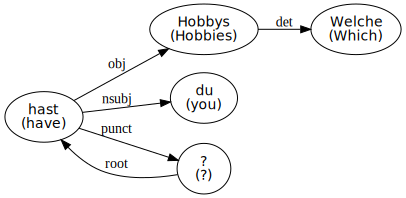

In [1]:
from sagas.nlu.corenlp_helper import LangDialect as dia
dia('de').ana('Welche Hobbys hast du ?')  # with word translation

text: Diese 	lemma: dies	upos: PRON	xpos: PDAT
text: Liga 	lemma: Liga	upos: NOUN	xpos: NN
text: ist 	lemma: sein	upos: AUX	xpos: VAFIN
text: die 	lemma: der	upos: DET	xpos: ART
text: beste 	lemma: gut	upos: ADJ	xpos: ADJA
text: Liga 	lemma: Liga	upos: NOUN	xpos: NN
text: , 	lemma: ,	upos: PUNCT	xpos: $,
text: glaube 	lemma: glauben	upos: VERB	xpos: VVFIN
text: ich 	lemma: ich	upos: PRON	xpos: PPER
text: . 	lemma: .	upos: PUNCT	xpos: $.
('Diese', '2', 'det')
('Liga', '6', 'nsubj')
('ist', '6', 'cop')
('die', '6', 'det')
('beste', '6', 'amod')
('Liga', '0', 'root')
(',', '8', 'punct')
('glaube', '6', 'parataxis')
('ich', '8', 'nsubj')
('.', '6', 'punct')


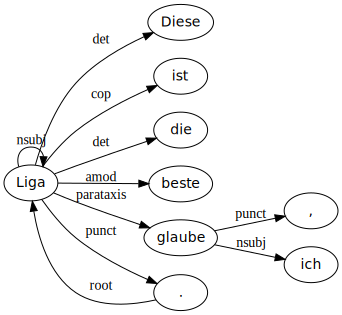

In [2]:
dia('de').ana_s('Diese Liga ist die beste Liga, glaube ich.')

In [3]:
def a_func():
    return 1,2
a_list=[a_func(), a_func()]
a_list

[(1, 2), (1, 2)]